# <center> Nah, I'd Document </center>

# Sections
1. Sections (<-- you are here)
1. Preamble
2. The Data
3. The Text Cleanup Engine
4. The Neural Network
5. The Performance
6. Hopes and the Future (<-- finish line)

# Preamble

Let's take a moment to set the stage, and provide some context. We gave the ML guy freedom to pick a documentation style of choice, and have here a mélange of the source code with, a pinch of salt at the ready, "*fun*" explanations.

Obligatory answers to FAQs unasked and unknown: Machine learning has revolutionized the field of you-name-it. It involves training models to take actions without being explicitly programmed. As I once put it, ***do the math, predict the future***. Or as Yoda never put it, ***the math you the future predict if do.*** Or as my engineering roommate once said, ***loda***.

The branch of predictions we tackle here is **Classification**: a type of supervised learning task where the goal is to assign labels, in our case a 0, meaning good, or a 1, meaning bad, to input text. Note the inversion from the usual meanings: for spam we measure unwantedness, after all. We will use a combination of algorithms and techniques to train models on a carefully prepared dataset, and evaluate their performance to see if the machine learned anything worthwhile after all.

Throughout this notebook, we will be working with a dataset that contains examples of hate speech and spam comments. The dataset is diverse and has been collected from a plethora of sources. We will preprocess the text data, train a **BiLSTM model** on **Stanford's GloVe**, and evaluate its performance using standard ML metrics -- the renowned and infamous: *accuracy, precision, recall, and F1 score.*

We believe the stage is set. Let's proceed to the next sections where we will explore the data, clean it, build the classification engine, train the neural network, and evaluate its performance.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from string import punctuation
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, LSTM, GRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import initializers, regularizers, constraints, optimizers, layers
from gensim.models import KeyedVectors
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# from google.colab import drive
# drive.mount('/content/drive')
!conda install -y gdown
!gdown 169CO95rNNcIUeesyUUNdiiyvkstJ2lEh
!gdown 1AO1tBhHIc2S7kj4S74KLaGdES1I8gEeI
!gdown 1bTSPMLzol0Blo4ona6IJbeN4tMe91pAT

!cp /kaggle/input/train14/train1.csv /kaggle/working
!cp /kaggle/input/train14/train1.csv /kaggle/working
!cp /kaggle/input/train14/train2.csv /kaggle/working
!cp /kaggle/input/train14/train3.csv /kaggle/working

w2v = KeyedVectors.load_word2vec_format('glove.6B.300d.word2vec.txt',binary=False)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Retrieving notices: ...working... done
done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.1.1

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.1.1



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2024.2.2   |       h

# <center> Data

Let's cut to the chase. Though you probably know this, no harm in saying it again: Machine learning **needs** data to *feed on*. Like, *devour*.

<p align="center">
  <img src="https://i.imgur.com/8UWlmBu.png" alt="cyanide, please"/>
</p>

In this section, we describe the data that we used in our experiments. First, we describe existing hate speech and spam comment datasets. Then, we unify those and provide statistics of the final data in our datasets.

In total, we collected datasets related to spam and hate in social media until we lost count ("spam dataset" was searched 37 times according to my Chrome history). The datasets selected are diverse both in content, different kinds of unwanted speech, and in a spatial-temporal aspect, that is to say, they've been gathered from sources spread over the internet over the years. We outline them below:

### Dataset Format
Training data was compiled into lots of CSVs until our ML guy got fed up of copying them to Colab and wrote a script to combine 'em. By the submission date we retained four of these, aptly labeled:
- train1.csv
- train2.csv
- train3.csv

And you guessed it:
- train4.csv

An analysis of their contents follows


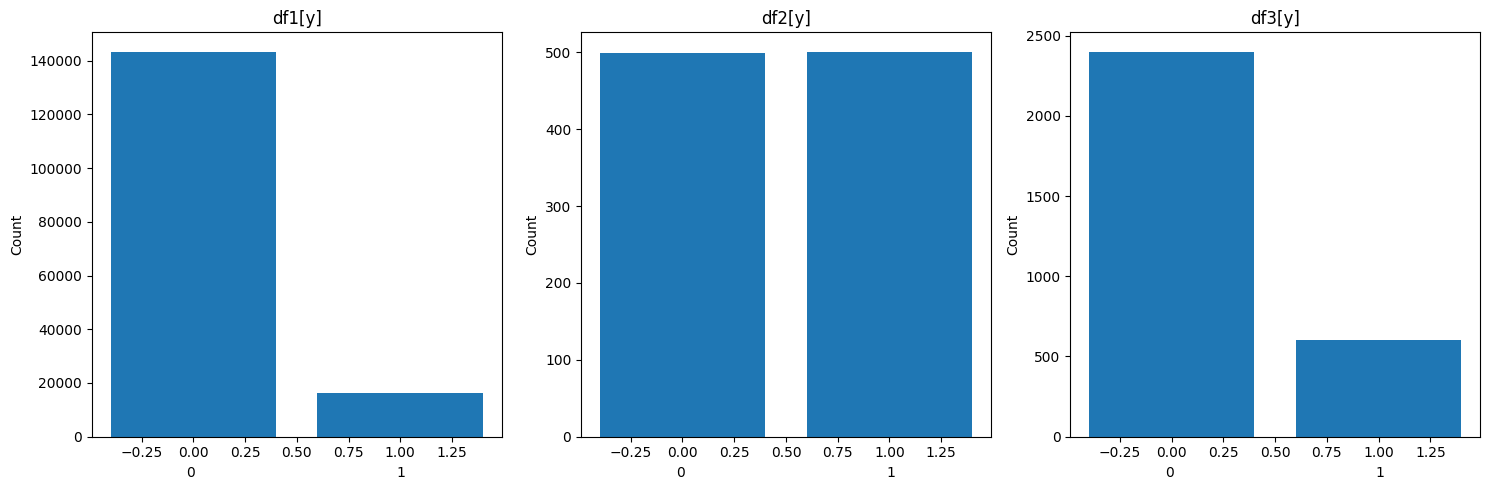

In [2]:
"""
Reads three CSV files ('train1.csv', 'train2.csv', 'train3.csv') into separate dataframes (df1, df2, df3).
Creates a figure with three subplots, each showing the count of labels in the corresponding dataframe.
"""

df1 = pd.read_csv('train1.csv')
df2 = pd.read_csv('train2.csv')
df3 = pd.read_csv('train3.csv')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
label01 = '0                                              1'
for (i, df) in enumerate([df1, df2, df3]):
    axes[i].bar(df['y'].value_counts().index, df['y'].value_counts().values)
    axes[i].set_title(f'df{i+1}[y]'); axes[i].set_xlabel(label01); axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

The name of the game here is eliminating imbalance in the training data. There are two players in this game: Our Model vs The ML guy. Their common goal is to maximize the number of correct predictions while putting in the least effort -- a championship where the victor is the laziest. Suppose the ML guy makes the first move and is too lazy to sample the data carefully. He trains the Model on all the data. The Model, as if to compete and even one-up this laziness, simply learns to predict 0 all the time. Since ~90% of the data is 0, the Model automatically has ~90% accuracy, and all our cutting-edge state-of-the-art machine learning machinery goes to waste -- all we raise is an optimistic wimp of a classifier that lacks any spine to call out spam for what it is.

Nevertheless, *Papa didn't raise no quitter*. The ML guy puts effort in sampling, the model puts effort in learning, and they both lose the championship of laziness. The winners are us.

In [3]:
shadow_banned_from_colab_GPUs = True
pivoted_to_kaggle_yet = False
# ...enthusiastic, are we

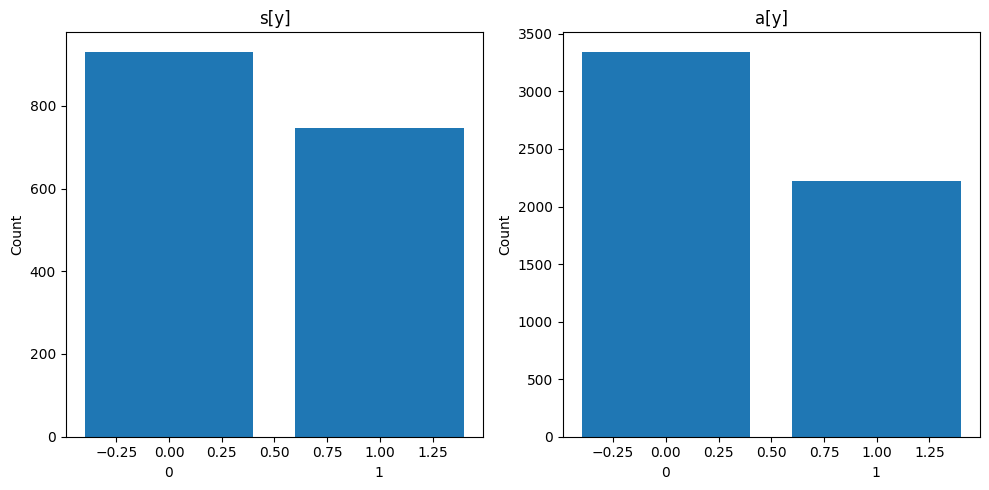

In [4]:
'''
Let's fix it. We'll use the first dataframe's excess of each label to balance the other two dataframes.
'''
count_label_0, count_label_1 = df1['y'].value_counts()
data_label_0 = df1[df1['y'] == 0]
data_label_1 = df1[df1['y'] == 1]
data_label_1_under = data_label_1.sample(count_label_1)
data_label_0_under = data_label_0.sample(count_label_1*3//2)
hate_df = pd.concat([data_label_0_under, data_label_1_under, df2, df3], axis=0).reset_index(drop=True).dropna()

if shadow_banned_from_colab_GPUs and not pivoted_to_kaggle_yet:
    hate_df = hate_df.sample(len(hate_df)//8)

'''
Let's handle the spam_df too while we're at it.
'''
!cp /kaggle/input/train14/train4.csv /kaggle/working
spam_df = pd.read_csv('train4.csv')
count_label_0, count_label_1 = spam_df['y'].value_counts()
data_label_0 = spam_df[spam_df['y'] == 0]; data_label_1 = spam_df[spam_df['y'] == 1]
data_label_1_under = data_label_1.sample(count_label_1); data_label_0_under = data_label_0.sample(count_label_1*5//4)
spam_df = pd.concat([data_label_0_under, data_label_1_under], axis=0).reset_index(drop=True).dropna()

DFs = ['hate_df', 'spam_df']

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, df in enumerate(['spam_df', 'hate_df']):
    axes[i].set_title(f'{df[i]}[y]')
    df = eval(df)
    axes[i].bar(df['y'].value_counts().index, df['y'].value_counts().values)
    axes[i].set_xlabel(label01)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

Good to go. Incidentally, the sources for this spatially-temporally sourced data include:
- Twitter
- Reddit
- 4chan
- That one notorious spam dataset we found literally everywhere we scoured

among others, the open-sourcedness of which we're awfully grateful to.



# Text Cleaning Engine
### <center> Do you preprocess text because you're the TCE, or are you the TCE because I'm you?</center>

### There are three chief preprocessing techniques:
* Regex Filters
* Lemmatizing
* Stemming

Out of which we employ all but the latter. Spoiler alert: It messes with something called embedding, which is critical to our model.

**1. Regex Filtering**: Basic Python methods and regular expressions exist that expand acronyms, remove urls, other characters than text, delete whitespace, etc. We also pass the text through a stopword filter, which removes common and vapid words like "this", "is", "a", etc.

**2. Lemmatizing**: THe process of reverting a word to its base form, or lemma. For example, 'was', 'is', 'will be' --> 'be'. It removes reliance on unnecessary words in the text corpus.

**3. Stemming _[Not Utilized]_**: Stemming takes lemmatization one step further, and cuts the ends of words into eldritch and evil-looking stemmed forms that are supposed to increase efficiency. For example: change, changed, changer, changes --> 'chang'

In [5]:
stopwords_set = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
def processed(text) -> list:
    text = text.lower()
    cont_patterns = [
        ('(W|w)on\'t', 'will not'),
        ('(C|c)an\'t', 'can not'),
        ('(I|i)\'m', 'i am'),
        ('(A|a)in\'t', 'is not'),
        ('(\w+)\'ll', '\g<1> will'),
        ('(\w+)n\'t', '\g<1> not'),
        ('(\w+)\'ve', '\g<1> have'),
        ('(\w+)\'s', '\g<1> is'),
        ('(\w+)\'re', '\g<1> are'),
        ('(\w+)\'d', '\g<1> would'),
    ]
    # Remove short forms
    patterns = [(re.compile(regex), repl) for regex, repl in cont_patterns]
    for pattern, repl in patterns: text = re.sub(pattern, repl, text)
    # Remove URLs
    text = re.sub(r"http\S+", "", text)
    # Only keep text
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Remove whitespace
    text = ' '.join(text.split())
    text = [word for word in word_tokenize(text) if word not in stopwords_set]
    # Lemmatize
    text = [lemmatizer.lemmatize(word) for word in text]

    return text

![](https://i.redd.it/t3feb4140n151.png)

Linear algebraists see the world through vectorized glasses. Not even text is safe -- enter Google's word2vec.

**Word2Vec Embedding**: The embedding is the hashmap behind word2vec's titular word to vector feature. English words in the embedding are mapped to vectors in 300 dimensions.

**GloVe Word2Vec**: aka Global Vectors is Stanford's open source pre-trained edition of word2vec. A cool consequence of the way they trained it is that the relative locations and distances in the <u>vector world</u> represent degree of synonymity and antonymity in the <u>semantic world</u>.  

Word vectorization via embeddings is robustly capable, quite interesting, and worth the detour we'll take for playing around with it a while.

In [6]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
# Here we'll store word embeddings
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open('glove.6B.300d.txt'))
# all_embs is stacking all the values in embeddings_index
all_embs = np.stack(list(embeddings_index.values()))
# Constants that'll be handy for normalization
emb_mean, emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]
# type(list(embeddings_index.values()))

In [7]:
z = w2v.doesnt_match("one to three four five six seven".split())
print(z);
'ans = to'

z = w2v.doesnt_match("rainy monsoon storm sky".split())
print(z);
'ans = sky'

z = w2v.doesnt_match("electron thunder taser zap".split())
print(z);
'ans = thunder'

# Lesbian - Woman + Man = ?
z = w2v.most_similar(['lesbian','man'],negative=['woman'],topn=1)
print(z);
# 'ans = gay'

to
sky
thunder
[('gay', 0.7044728398323059)]


In [8]:
import nltk
import subprocess

# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

# Now you can import the NLTK resources as usual - StackOverflow
from nltk.corpus import wordnet
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
hate_df['Text'] = hate_df['Text'].apply(lambda x: processed(x))
spam_df['Text'] = spam_df['Text'].apply(lambda x: processed(x))

[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordnet/README  
  inflating: /kaggle/working/corpora/wordnet/index.sense  
  inflating: /kaggle/working/corpora/wordnet/data.

# The Neural Network
### The Basics:
- NN: A neural network is a unidirected graph where each edge stores a weight. Lots of LinAL, and backpropagation-tuned weights help the network minimize a differentiable loss function.

- RNN: If NNs are one of those sequential circuits from EE101, where data flows in one direction, then RNNs are the flipflops that feed back into themselves. Looping data into themselves allows Recurrent Neural Networks to rememember (i) their weights, and (ii) memory of previous states.

- LSTM: Long Short-Term Memory, a superior adaptation of RNNs. RNNs work on long sequential data and backpropagation has the risk of reducing (resp. increasing) certain gradients until they vanish (resp. explode). The vanishing (exploding) gradients problem is tackled by LSTMs and their unique design makes them a favorite choice for language processing.


Our architecture is a BiLSTM: Bidirectional LSTM. One direction faces the future, the other the past, and together they're supposed to offer much better comprehension of the sequential data.

## The Performance
### We apply standard performance metrics, namely, accuracy, recall, precision and F1-score.

A few preliminary terms:
- True Positive: Model is right in finding hate
- True Negative: Model is right in finding gucci
- False Positive: Model is wrong in finding hate
- False Negative: Model is wrong in finding gucci

The Basic Metric formulas:
- Accuracy = $\frac{TN+TP}{TN+TP+FN+FP}$

- Recall = $\frac{TP}{TP+FN}$

- Precision = $\frac{TP}{TP+FP}$

- F1 = $\frac{2}{\frac{1}{Prec} + \frac{1}{Rec}}$ = $\frac{2(Prec)Rec}{Prec + Rec}$


In [9]:
DFs = ['hate_df','spam_df']
for df in DFs:
    modelname = df
    print(f'{df}')
    df = eval(df)
    df = df[df['Text'].apply(lambda x: type(x) is list)]
    df.dropna(subset=['Text'])
    X = df['Text']; y = df['y']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    maxlen = 2000
    max_features = len(df)
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(X_train)
    word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i-1] = embedding_vector

    X_train = np.array(tokenizer.texts_to_sequences(X_train), dtype='object')
    X_test  = np.array(tokenizer.texts_to_sequences(X_test), dtype='object')
    X_train = pad_sequences(X_train,maxlen=maxlen)
    X_test  = pad_sequences(X_test, maxlen=maxlen)

    inp = Input(shape=(maxlen,))

    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = Bidirectional(LSTM(64, return_sequences=True))(x) # BiLSTM, the core layer of the model
    x = GlobalMaxPool1D()(x) # Select max value from the ortho direction to reduce to columm vector
    x = Dense(16, activation="relu")(x) # Vanilla
    x = Dropout(0.4)(x) # Prune 40%
    x = Dense(1, activation="sigmoid")(x) # This is the layer that makes our model a classifier

    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.layers[1].trainable = False # To not disturb the GloVe models
    print(model.summary())

    history = model.fit(
                X_train, y_train, batch_size=512, epochs=10, #20,
                validation_data=(X_test, y_test),
                callbacks = [EarlyStopping(monitor='val_accuracy', patience=1)] # To stop once val_acc drops
            )

    from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
    y_predict  = [1 if o>0.5 else 0 for o in model.predict(X_test)]
    print(confusion_matrix(y_test,y_predict))

    tn, fp, fn, tp = confusion_matrix(y_test,y_predict).ravel()
    print("Accuracy: {:.2f}%".format(100 * accuracy_score(y_test, y_predict)))
    print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_predict)))
    print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_predict)))
    print("F1 of", f1_score(y_test,y_predict))

    # save this model
    model.save(modelname+'.h5')


hate_df
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 embedding (Embedding)       (None, 2000, 300)         1670700   
                                                                 
 bidirectional (Bidirection  (None, 2000, 128)         186880    
 al)                                                             
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dropout (Dropout)           (None, 16)              

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2000)]            0         
                                                                 
 embedding_1 (Embedding)     (None, 2000, 300)         503400    
                                                                 
 bidirectional_1 (Bidirecti  (None, 2000, 128)         186880    
 onal)                                                           
                                                                 
 global_max_pooling1d_1 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_2 (Dense)             (None, 16)                2064      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0   

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### Our ML guy was totally not blacklisted on Colab for abuse of GPU. A shame if this error message makes it to the final documentation.

In [10]:
''' Save the tokenizers '''

import json, io
tokenizer_hate = Tokenizer(num_words=len(hate_df))
tokenizer_hate.fit_on_texts(train_test_split(hate_df['Text'], hate_df['y'], test_size=0.2, random_state=42)[0])
tokenizer_spam = Tokenizer(num_words=len(spam_df))
tokenizer_spam.fit_on_texts(train_test_split(spam_df['Text'], spam_df['y'], test_size=0.2, random_state=42)[0])
with io.open('tokenizer_hate.json', 'w', encoding='utf-8') as f: f.write(json.dumps(tokenizer.to_json(), ensure_ascii=False))
with io.open('tokenizer_spam.json', 'w', encoding='utf-8') as f: f.write(json.dumps(tokenizer.to_json(), ensure_ascii=False))

In [11]:
''' Export suite '''
# %cp 'hate_df.h5' /content/drive/MyDrive/Pipeline/
# %cp 'spam_df.h5' /content/drive/MyDrive/Pipeline/
# %cp 'tokenizer_spam.json' /content/drive/MyDrive/Pipeline/
# %cp 'tokenizer_hate.json' /content/drive/MyDrive/Pipeline/

' Export suite '

In [12]:
''' Import suite '''
# %cp /kaggle/input/loadmodel/hate_model.h5 /kaggle/working
!gdown 1bTSPMLzol0Blo4ona6IJbeN4tMe91pAT

%cp /kaggle/input/loadmodel/spam_model.h5 /kaggle/working
%cp /kaggle/input/tokens/tokenizer_hate.json /kaggle/working
%cp /kaggle/input/tokens/tokenizer_spam.json /kaggle/working

In [17]:
# load this model
from keras.models import load_model
from keras.preprocessing.text import tokenizer_from_json

hate_model = load_model('hate_model.h5')
spam_model = load_model('spam_model.h5')
with open('tokenizer_hate.json') as f: tokenizer_hate = tokenizer_from_json(json.load(f))
with open('tokenizer_spam.json') as f: tokenizer_spam = tokenizer_from_json(json.load(f))


class Model:
    def __init__(self, model, tokenizer) -> None:
        self.model = model
        self.tokenizer = tokenizer
    def predict(self,vec) -> float:
        try: vec = processed(vec)
        except: pass
        vec = np.array(self.tokenizer.texts_to_sequences(vec), dtype='object')
        vec = pad_sequences(vec,maxlen=2000)
        rating = 100*self.model.predict(vec)[0,0]
        return rating

HateModel = Model(hate_model, tokenizer_hate)
SpamModel = Model(spam_model, tokenizer_spam)

In [22]:
vec = "You son of a gun I'm coming for you"
print(f'{HateModel.predict(vec)}% hate')
# 20%

vec = "You bastard I'm fucking coming for you"
print(f'{HateModel.predict(vec)}% hate')
# 98%

1/1 [==============================] - 0s 55ms/step
20.909401774406433% hate
1/1 [==============================] - 0s 60ms/step
98.61706495285034% hate


In [32]:
vec = input("[INPUT]")
print("A hate analysis")
print(HateModel.predict(vec))
print("A spam analysis")
print(SpamModel.predict(vec))

[INPUT] entry fucking free. win ipod daily


A hate analysis
1/1 [==============================] - 0s 56ms/step
2.3213785141706467
A spam analysis
1/1 [==============================] - 0s 67ms/step
22.523237764835358


# Hopes and the Future

In the future we desire to extend our datasets to
- fix whatever went wrong in that last cell
- identify more varieties of spam
- add support for Hinglish comments